# e-Health Africa Assessment Section A

### Case Study

A client in the health sector has just completed a survey of health facilities across the country, and a ranking of health facilities based on the availability of key personnel was done. We have received a request from this client to prepare a map showing the distribution of these health facilities across various senatorial districts, highlighting on the map the best ranked for each senatorial district.

### Dataset

- A zip folder containing the dataset and the necessary assests to complete the questions

### Actions
1. Transformed by means of automation, the document ‘LGA_SEN_Districts’ into a well-structured database table that anyone can easily work with. You are free to use any ETL (extract, transform and load) software or scripting language of your choice to carry out this operation.

2. Export all final (processed) datasets in an SQLite database

3. Make a map in QGIS showing the senatorial districts, highlighting health facilities with the best scores.

4. Include the necessary map elements and export your map in PDF and on A3 paper size.


**Next:** We will go ahead to import the necessary python libraries to ingest and prepare the data



In [51]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import zipfile
import os

In [52]:
import gdown

# url = "https://drive.google.com/drive/folders/0B_QbxVKE__XpUVlkaFYxemFqcVk"  # Replace YOUR_FOLDER_ID
# output_path = "downloaded_folder"  # Desired local path for the downloaded folder

# gdown.download_folder(url, output=output_path, quiet=True) 
# print(f"Folder downloaded to: {output_path}")

### Data Gathering

In [53]:

url = "https://drive.google.com/file/d/0B_QbxVKE__XpUVlkaFYxemFqcVk/view?resourcekey=0-izqqoqXBj6xDfOyZHB61Gw"
output = "datasets.zip"
# Download
# gdown.download(url, output, quiet=False)


In [54]:
dest_dir=output.split(".")[-2]
try:
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f"{output} was successfully extracted to {dest_dir}")
except Exception as e:
    print(f"An error occured: {e}")


datasets.zip was successfully extracted to datasets


In [55]:
# ingest health facility data
rel_path = "test/datasets"
df_hr=pd.read_csv(os.path.join(rel_path,'hf_locations.csv'),encoding="ISO-8859-1")
#check null values
print(df_hr.isnull().sum()[df_hr.isnull().sum()>0])
#ingest senatorial district data
df_lg=pd.read_excel(os.path.join("pre_processed_data",'LGA_SEN_Districts.xlsx'))

hf_name    1
dtype: int64


### Data Assessment
The `hf_locations` and `LGA_SEN_District` were both assessed visually in Excel and programatically for data quality is issues. The following oberservations were made

**for hf_locations**
- senatorial_district column contains some characters, `\x96`,`–` which are unwanted
**for LGA_SEN_District**
- State names were not organized
- senatorial districts for a were clung up in a row separated
- district column contains double space characters


### Data cleaning
We will go ahead to clean up the data, addressing all the quality issues itemized above

In [56]:
# remove unwanted characters
df_hr.senatorial_district=df_hr.senatorial_district.str.strip().str.replace("\x96",'-')
df_hr.senatorial_district=df_hr.senatorial_district.str.replace('–', '-', regex=False)

In [57]:

df_lg=df_lg.dropna(how="all")
df_lg=df_lg.iloc[0:,:]
df2=df_lg.reset_index(drop=True)
# df2.columns=df2.iloc[2,:]
df2.columns=['state_name','senatorial_district','state_code','composition','collation_centre']

In [58]:
exclusive_list=list(range(0,len(df_lg)))
exclusive_list.append("S/N")

df2.state_name=df2.state_name.apply(lambda x: np.nan if x in exclusive_list else x)
df2['state_name']=df2.senatorial_district.str.split().str[0].str.title()
df2['state_name']=df2['state_name'].replace({'Akwa':'Akwa Ibom','Cross':'Cross River','Federal':'Federal Capital Territory'})
df2.dropna(subset=['senatorial_district','state_code'],how='all',inplace=True)
df2=df2[~(df2.state_code.str.strip()=='CODE')].reset_index(drop=True)



In [59]:
# split up the the district into different dataframe
temp_ = df2["composition"].str.split(", ").explode().reset_index()
temp_.columns = ["orig_index", "district_composition"]

#merge back district with the original table
dfc = df2.merge(temp_, left_index=True, right_on="orig_index")
dfc.drop(columns=['composition','orig_index'],inplace=True)

In [60]:
# Normalize columns to sentence case
for col in ['state_name','senatorial_district','district_composition']:
    dfc[col]=dfc[col].str.strip().str.title()

## replace characters
dfc.senatorial_district=dfc.senatorial_district.str.replace("  "," ") 
dfc.senatorial_district=dfc.senatorial_district.str.replace('–', '-', regex=False)  

In [61]:
# merge hr_locations and the senatorial district data
df=df_hr.merge(dfc[['state_code','state_name','senatorial_district','collation_centre']],
               on=['state_name','senatorial_district'],how='left')

In [62]:
#raise error when there is no match at all
assert (len(df[df.state_code.isnull()])==0)

> #### Observation
> The assert function throws no error, meaning both data set where merged sucessfully on state name and the senatorial district without any conflict. 

## Map Production

We will use python libraries to prepare the shape files and the facility score and visualize using matplotlib

In [63]:
import geopandas as gpd
from shapely.geometry import Point

In [64]:
# !pip install geopandas

In [65]:
districts=gpd.read_file(os.path.join(rel_path,'admin_bndry.shx'))

In [66]:
scores = gpd.read_file(os.path.join(rel_path,'hf_personnel_scoring.tab'))
# Convert N/A to NaN and ensure numeric
scores["hf_total_score"] = pd.to_numeric(scores["hf_total_score"], errors="coerce")

In [67]:


# Join with health facilities on UUID
hf_with_scores = df.merge(
    scores,
    left_on="globalid",
    right_on="hf_uuid",
    how="left"
)

print("rows, cols:", hf_with_scores.shape)
hf_with_scores.head(3)


rows, cols: (1516, 11)


,hf_name,latitude,longitude,state_name,lga_name,senatorial_district,globalid,state_code,collation_centre,hf_total_score,hf_uuid
0,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0
1,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0
2,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0


In [68]:
assert(len(hf_with_scores[hf_with_scores.globalid.isnull()])==0)

In [69]:
gdf = gpd.GeoDataFrame(
    hf_with_scores,  
    geometry=gpd.points_from_xy(hf_with_scores.longitude, hf_with_scores.latitude),
    crs="EPSG:4326"  # WGS84 lat/long
)


In [70]:
# compute geometry from latittude & longitude
hf_with_scores["geometry"] = hf_with_scores.apply(
    lambda row: Point(row["longitude"], row["latitude"]), axis=1
)

# Convert to GeoDataFrame
hf_gdf = gpd.GeoDataFrame(hf_with_scores, geometry="geometry", crs="EPSG:4326")
districts = districts.to_crs(epsg=4326)


In [82]:
hf_gdf.head()

,hf_name,latitude,longitude,state_name,lga_name,senatorial_district,globalid,state_code,collation_centre,hf_total_score,hf_uuid,geometry
0,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,POINT (7.4731 5.58538)
1,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,POINT (7.4731 5.58538)
2,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,POINT (7.4731 5.58538)
3,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,POINT (7.4731 5.58538)
4,Umuokehi Primary Health Centre,5.585375,7.473098,Abia,Umuahia North,Abia Central,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,SD/002/AB,COUNCIL HALL UMUAHIA NORTH LGA HQS,5.0,2d5c9c5e-7626-46f9-b581-dcdc3e4c31e0,POINT (7.4731 5.58538)


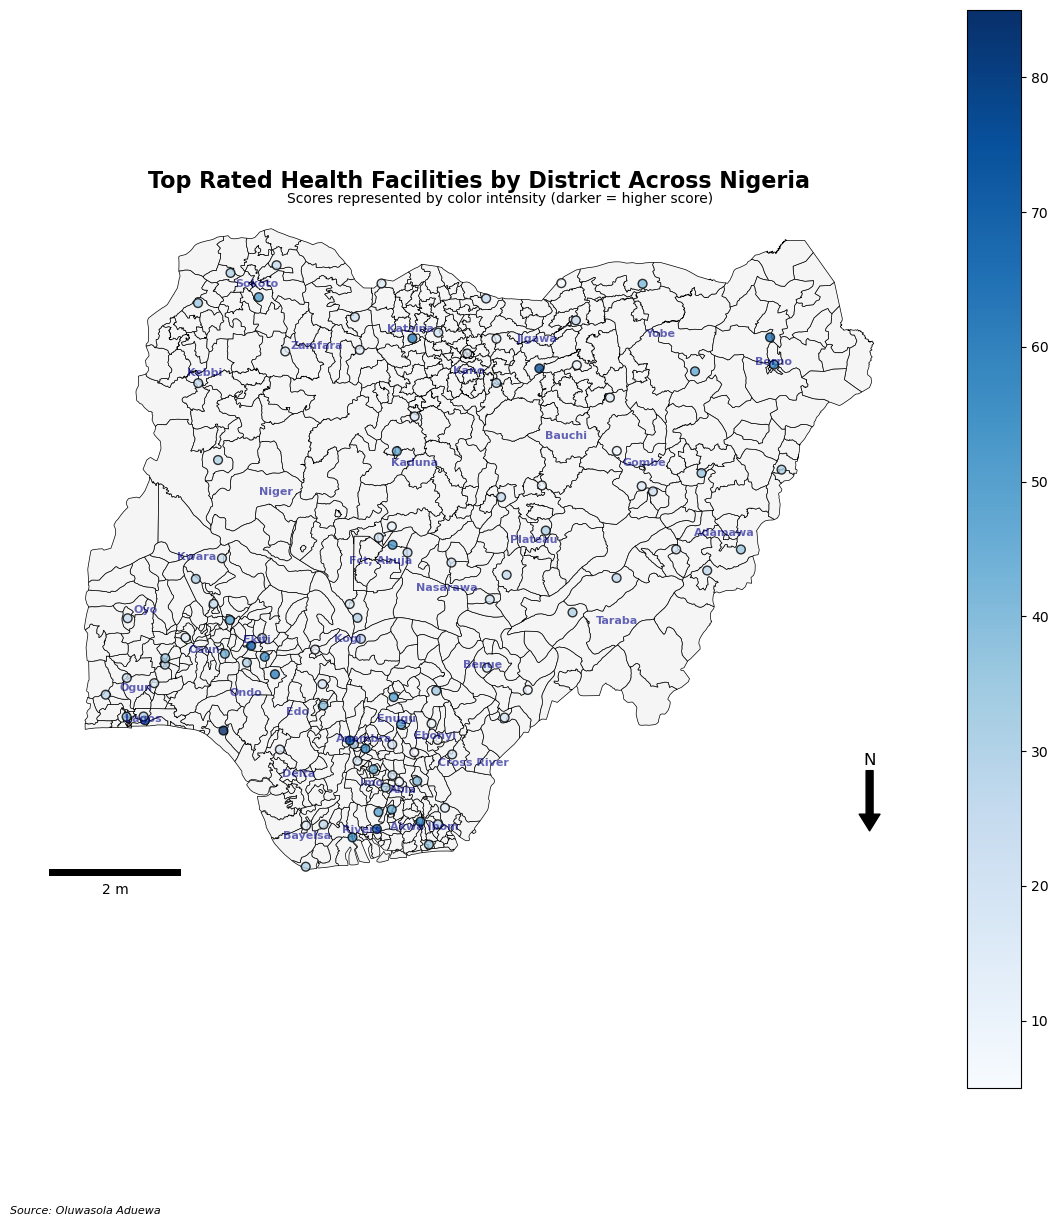

In [104]:
# hf_gdf
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 14))

# Plot districts
districts.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=0.5)
hf_valid = hf_gdf.dropna(subset=["hf_total_score", "senatorial_district"])
top_hf = hf_valid.loc[
    hf_valid.groupby("senatorial_district")["hf_total_score"].idxmax()]

# Plot facilities with better style
top_hf.plot(
    ax=ax,
    column="hf_total_score",
    cmap="Blues",
    legend=True,
    markersize=40,
    alpha=0.8,
    edgecolor="black",

)

# Label states at centroids (fix)
states = districts.dissolve(by="statename")  # merge polygons by state
for idx, row in states.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        idx, 
        ha="center", va="center",
        fontsize=8, fontweight="bold",
        color="darkblue", alpha=0.6,
        
    )

# Add scale bar
scalebar = ScaleBar(1, location="lower left",rotation='horizontal-only') 
ax.add_artist(scalebar)

# Add north arrow
ax.annotate('N', xy=(0.95, 0.1), xytext=(0.95, 0.2),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12,
            xycoords=ax.transAxes)

# Title + Source
plt.title("Top Rated Health Facilities by District Across Nigeria", fontsize=16, weight="bold")
plt.suptitle("Scores represented by color intensity (darker = higher score)", fontsize=10, y=0.75,x=0.45)
plt.figtext(0.1, 0.02, "Source: Oluwasola Aduewa", ha="left", fontsize=8, style="italic")

plt.axis("off")
plt.savefig("top_rated_hf_by_district_map.pdf", format="pdf", bbox_inches="tight")
plt.show()



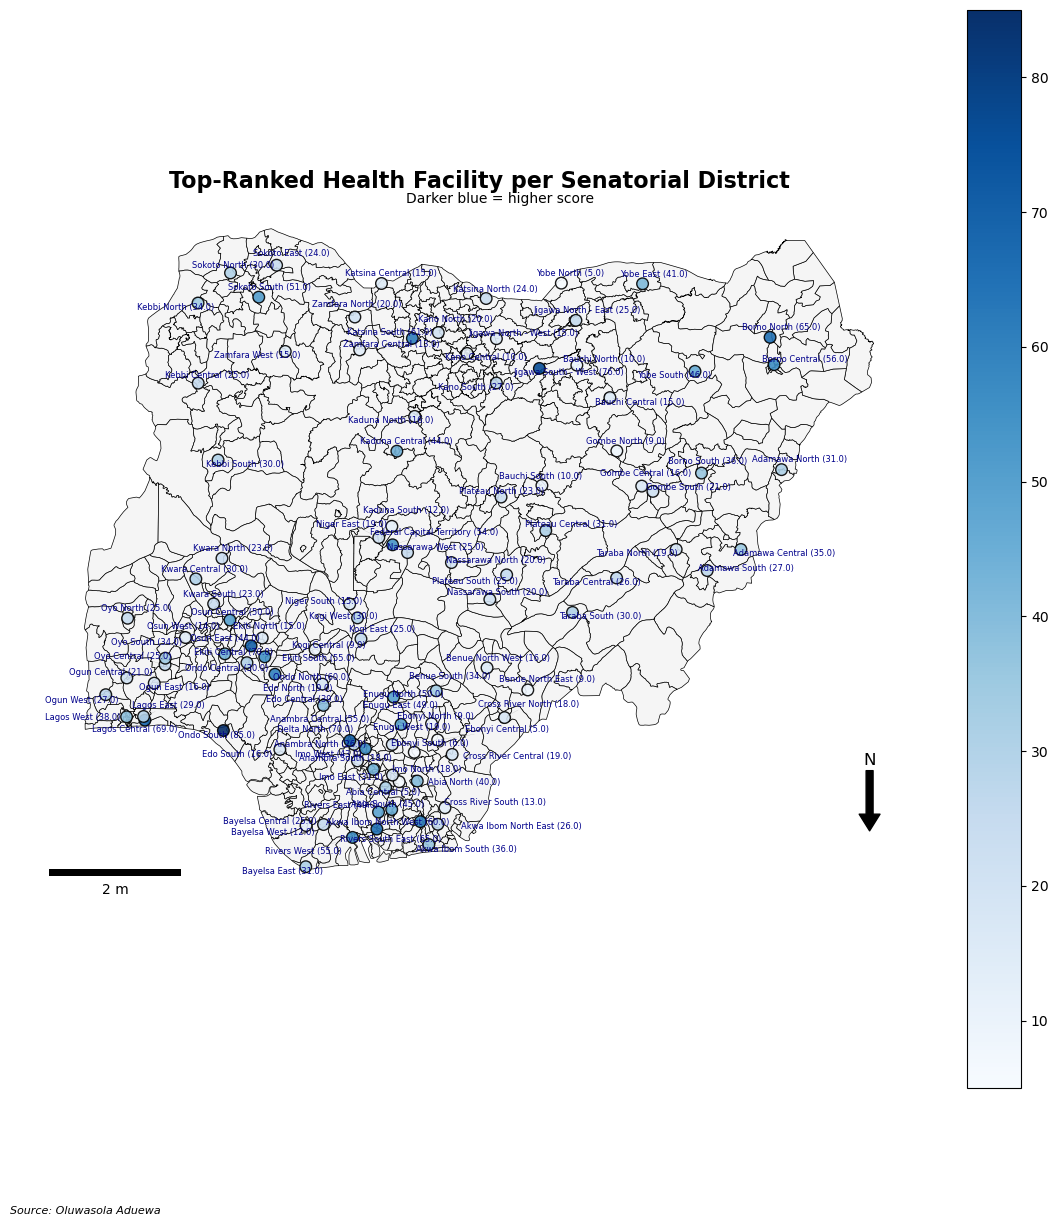

In [98]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from adjustText import adjust_text

fig, ax = plt.subplots(figsize=(14, 14))

# Plot districts
districts.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=0.5)

# Drop missing values before selecting top facilities
hf_valid = hf_gdf.dropna(subset=["hf_total_score", "senatorial_district"])

# Keep only max score facility per senatorial district
top_hf = hf_valid.loc[
    hf_valid.groupby("senatorial_district")["hf_total_score"].idxmax()
]

# Plot only those facilities
top_hf.plot(
    ax=ax,
    column="hf_total_score",
    cmap="Blues",        # blue gradient (darker = higher score)
    legend=True,
    markersize=70,
    alpha=0.9,
    edgecolor="black"
)

# Prepare labels (use adjustText to avoid clutter in dense areas)
texts = []
for idx, row in top_hf.iterrows():
    texts.append(ax.text(
        row.geometry.x, row.geometry.y,
        f"{row['senatorial_district']} ({row['hf_total_score']})",
        fontsize=6, ha="center", va="bottom",
        color="darkblue", #weight="bold"
    ))

# Adjust text placement to avoid overlaps
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color="gray", lw=0.1,))

# Add scale bar
scalebar = ScaleBar(1, location="lower left", rotation='horizontal-only')  
ax.add_artist(scalebar)

# Add north arrow
ax.annotate('N', xy=(0.95, 0.1), xytext=(0.95, 0.2),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12,
            xycoords=ax.transAxes)

# Title + Source
plt.title("Top-Ranked Health Facility per Senatorial District", fontsize=16, weight="bold")
plt.suptitle("Darker blue = higher score", fontsize=10, y=0.75, x=0.45)
plt.figtext(0.1, 0.02, "Source: Oluwasola Aduewa", ha="left", fontsize=8, style="italic")

plt.axis("off")
plt.savefig("top_health_facilities_map.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [88]:
# !pip install adjustText

### Create Map that Summarizes Nigeria Health Facilities By Their Scores

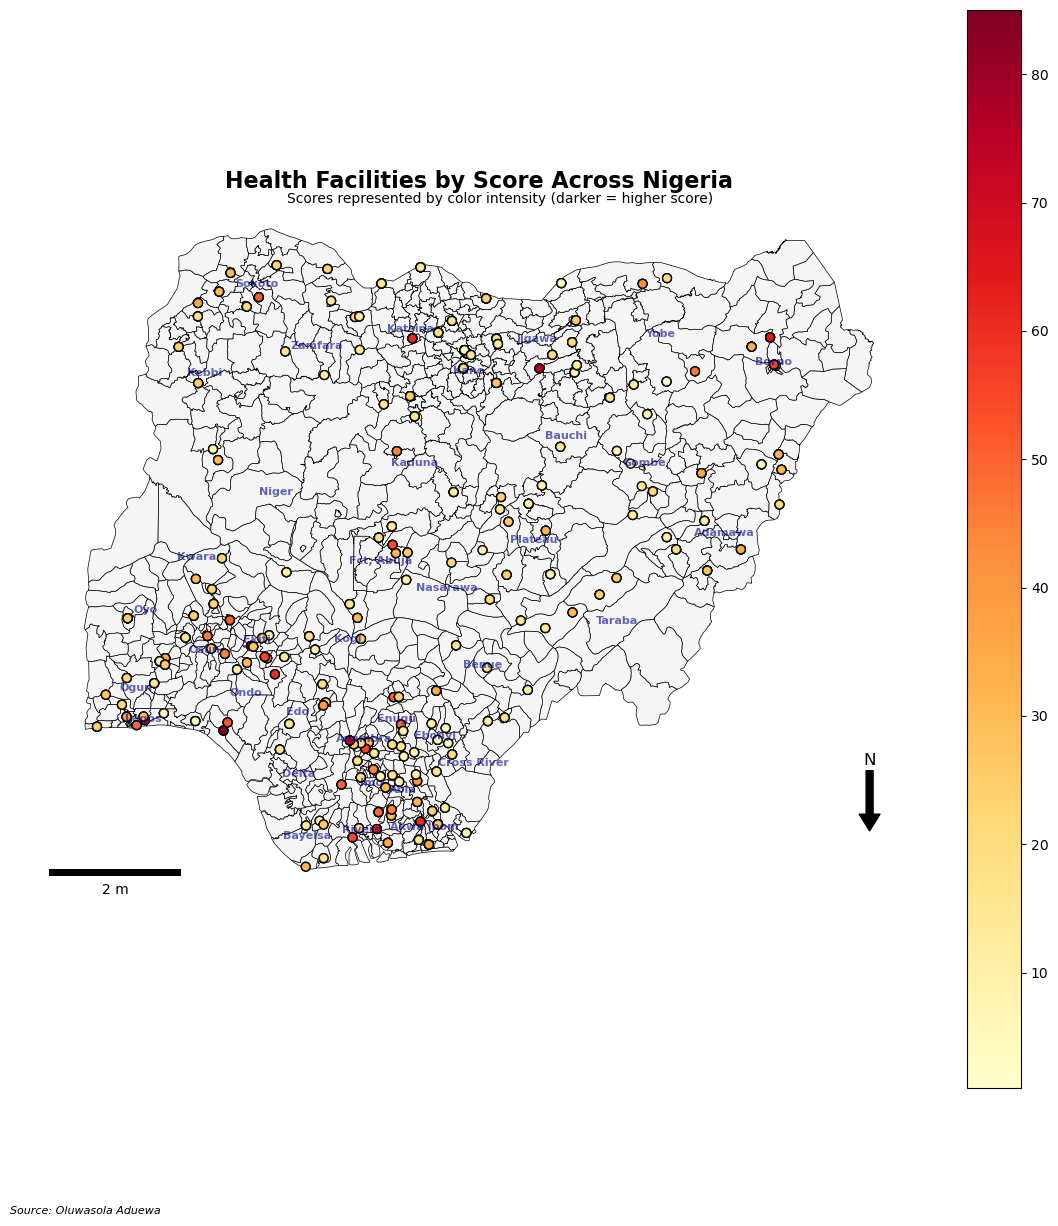

In [73]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 14))

# Plot districts
districts.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=0.5)

# Plot facilities with better style
hf_gdf.plot(
    ax=ax,
    column="hf_total_score",
    cmap="YlOrRd",
    legend=True,
    markersize=40,
    alpha=0.8,
    edgecolor="black",

)

# Label states at centroids (fix)
states = districts.dissolve(by="statename")  # merge polygons by state
for idx, row in states.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        idx, 
        ha="center", va="center",
        fontsize=8, fontweight="bold",
        color="darkblue", alpha=0.6,
        
    )

# Add scale bar
scalebar = ScaleBar(1, location="lower left",rotation='horizontal-only') 
ax.add_artist(scalebar)

# Add north arrow
ax.annotate('N', xy=(0.95, 0.1), xytext=(0.95, 0.2),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12,
            xycoords=ax.transAxes)

# Title + Source
plt.title("Health Facilities by Score Across Nigeria", fontsize=16, weight="bold")
plt.suptitle("Scores represented by color intensity (darker = higher score)", fontsize=10, y=0.75,x=0.45)
plt.figtext(0.1, 0.02, "Source: Oluwasola Aduewa", ha="left", fontsize=8, style="italic")

plt.axis("off")
plt.savefig("health_facilities_map.pdf", format="pdf", bbox_inches="tight")
plt.show()



## Prepare Data for SQLITE3 Database

The resulting data from the merger now becomes our primary dataframe. We will go ahead and design an entity relationship diagram for this data.

## Entity Relationship Diagram

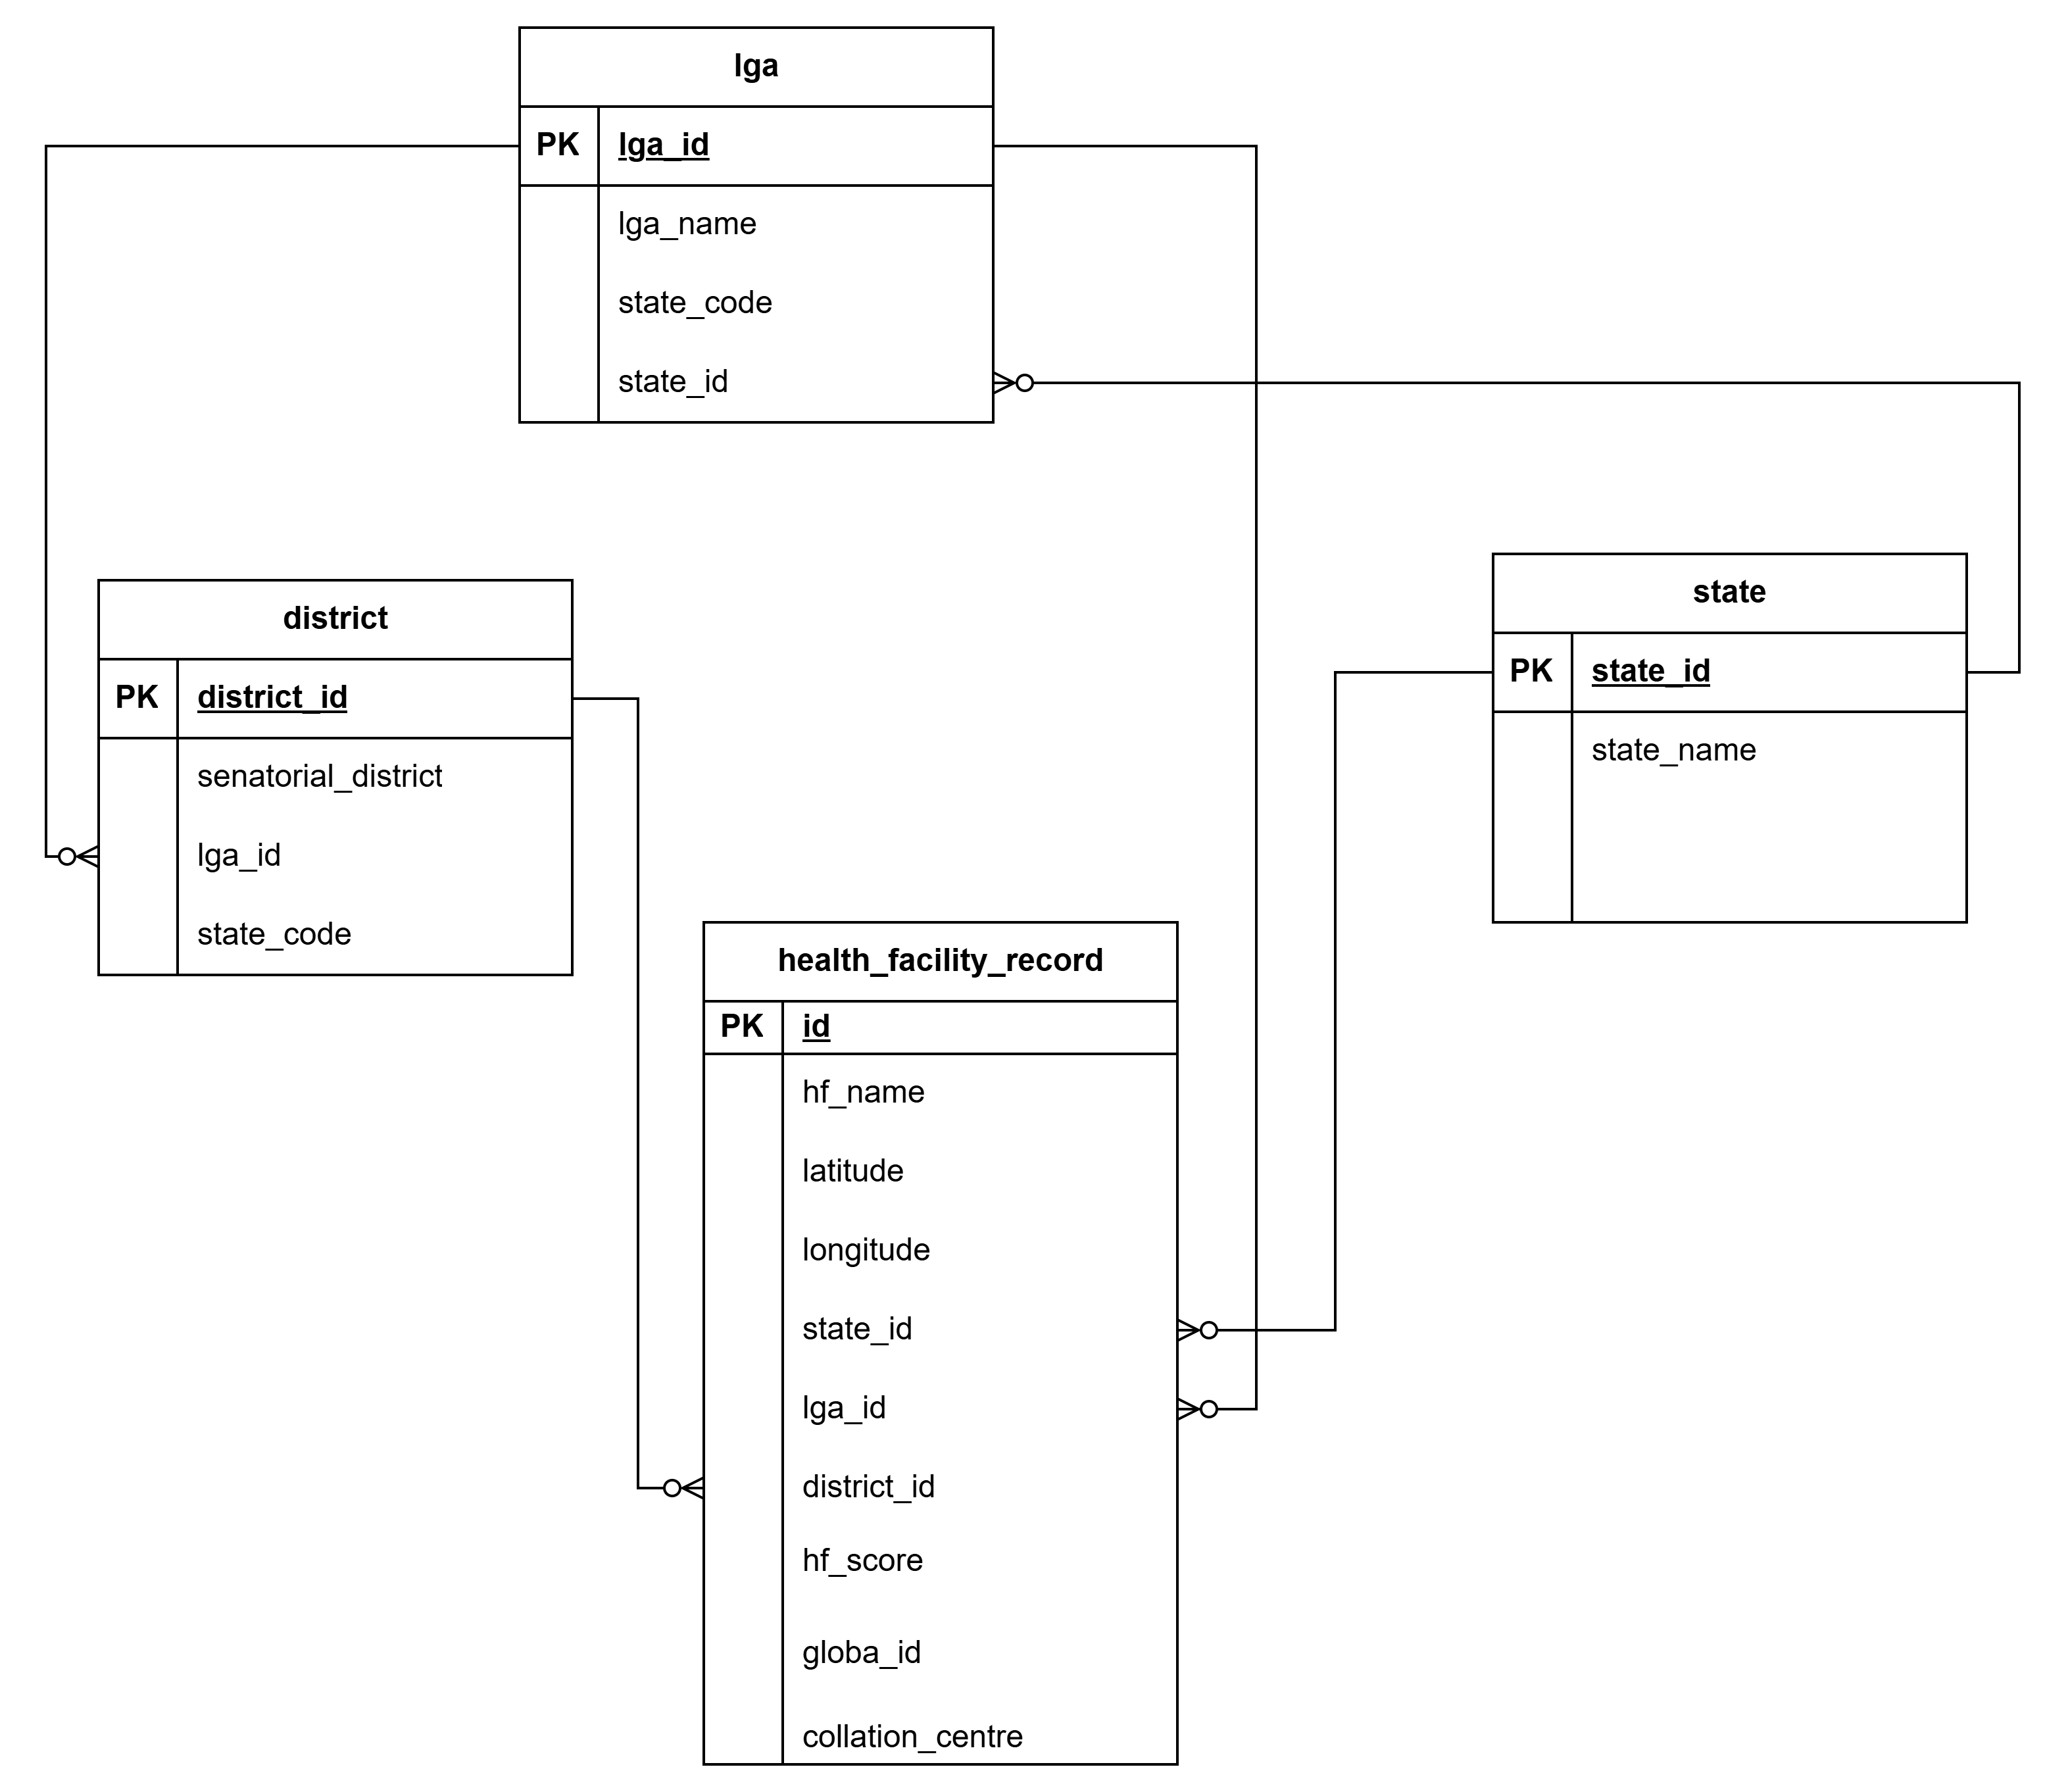

In [26]:
state_df=hf_with_scores[['state_name']].drop_duplicates().reset_index(drop=True)
state_df.state_name=state_df.state_name.sort_values()
state_df['id']=state_df.index+1
df_state=state_df[['id','state_name']]
df_state.head()

,id,state_name
0,1,Abia
1,2,Adamawa
2,3,Akwa Ibom
3,4,Anambra
4,5,Bauchi


In [27]:
lga_df = hf_with_scores[['lga_name','state_code']].drop_duplicates()
df_lga = lga_df.sort_values('lga_name').reset_index(drop=True)
df_lga['id']=df_lga.index+1
df_lga=df_lga[['id','lga_name','state_code']]
df_lga.head()


,id,lga_name,state_code
0,1,Aba South,SD/003/AB
1,2,Abak,SD/008/AK
2,3,Abeokuta South,SD/079/OG
3,4,Aboh Mbaise,SD/046/IM
4,5,Adavi,SD/064/KG


In [28]:
sen_df=hf_with_scores[['senatorial_district','state_code','lga_name']].drop_duplicates().sort_values('senatorial_district')\
.reset_index(drop=True)#.shape
sen_df['id']=sen_df.index+1
df_sen=sen_df[['id','senatorial_district','state_code','lga_name']]
df_sen.head()

,id,senatorial_district,state_code,lga_name
0,1,Abia Central,SD/002/AB,Umuahia North
1,2,Abia Central,SD/002/AB,Isiala Ngwa South
2,3,Abia North,SD/001/AB,Arochukwu
3,4,Abia North,SD/001/AB,Ohafia
4,5,Abia South,SD/003/AB,Aba South


In [46]:
# prepare fact table
df_all=hf_with_scores.merge(df_state.rename(columns={'id': 'state_id'}),on='state_name').\
merge(df_lga.rename(columns={'id': 'lga_id'}), on=['lga_name','state_code']).\
merge(df_sen.rename(columns={'id': 'district_id'}),on=['senatorial_district','state_code','lga_name'])

facility_df=df_all[['hf_name','latitude','longitude','state_id','lga_id','district_id','hf_total_score','globalid','collation_centre']].\
drop_duplicates().sort_values('hf_name').reset_index(drop=True).rename(columns={'globalid':'global_id'}) 

# insert id
facility_df.insert(0, 'facility_id', facility_df.index + 1)

In [47]:
lga=df_all[['lga_id','lga_name','state_id','state_code']].drop_duplicates().\
sort_values('lga_id').reset_index(drop=True)

state=df_all[['state_id','state_name']].drop_duplicates().sort_values('state_id').\
reset_index(drop=True)

district=df_all[['district_id','senatorial_district','state_code','lga_id']].drop_duplicates().sort_values('district_id').\
reset_index(drop=True)

In [48]:
import sqlite3
import pandas as pd

# Example: replace with your actual DataFrames
# state, district, lga, facility_df

# Connect to SQLite (creates file if not exists)
conn = sqlite3.connect("health_facilities.db")
cursor = conn.cursor()

# Drop tables if already exist (for clean rerun)
cursor.executescript("""
DROP TABLE IF EXISTS health_facility_record;
DROP TABLE IF EXISTS lga;
DROP TABLE IF EXISTS district;
DROP TABLE IF EXISTS state;
""")

# Create schema
cursor.executescript("""
CREATE TABLE state (
    state_id     INTEGER PRIMARY KEY,
    state_name   TEXT NOT NULL UNIQUE
);

CREATE TABLE district (
    district_id         INTEGER PRIMARY KEY,
    senatorial_district TEXT NOT NULL,
    state_code          TEXT NOT NULL,
    lga_id          TEXT NOT NULL
    
);

CREATE TABLE lga (
    lga_id      INTEGER PRIMARY KEY,
    lga_name    TEXT NOT NULL,
    state_code  TEXT NOT NULL,
    state_id    INTEGER NOT NULL,
    FOREIGN KEY (state_id) REFERENCES state(state_id),
    UNIQUE(lga_name, state_id)
);

CREATE TABLE health_facility_record (
    facility_id    INTEGER PRIMARY KEY,
    hf_name        TEXT,
    latitude       REAL,
    longitude      REAL,
    global_id      TEXT UNIQUE,
    hf_total_score REAL,
    state_id       INTEGER NOT NULL,
    lga_id         INTEGER NOT NULL,
    district_id    INTEGER NOT NULL,
    collation_centre TEXT,
    FOREIGN KEY (state_id) REFERENCES state(state_id),
    FOREIGN KEY (lga_id) REFERENCES lga(lga_id),
    FOREIGN KEY (district_id) REFERENCES district(district_id)
);
""")

# Insert data into each table
state.to_sql("state", conn, if_exists="append", index=False)
district.to_sql("district", conn, if_exists="append", index=False)
lga.to_sql("lga", conn, if_exists="append", index=False)
facility_df.to_sql("health_facility_record", conn, if_exists="append", index=False)

conn.commit()
conn.close()


### Conclusion

constraint was avoided on the health_facility_record table on column,hr_name because of a missing value in the primary health facility dataset
